In [1]:
import pandas as pd
import numpy as np

In [2]:
current_facilities = pd.read_csv("../data/ermera_full/current_facs.csv")
current_facilities["is_built"] = 1
current_facilities = current_facilities.drop(columns=["Hosp_Name"])
current_facilities.columns = ["Pop_Lat", "Pop_Lon", "Population", "Grid_Lat", "Grid_Lon", "Distance_KM", "is_built"]

In [3]:
data_potential = pd.read_csv("../data/ermera_full/grid.csv")
data_potential["is_built"] = 0

In [4]:
#data = pd.concat([data_potential, current_facilities], ignore_index=True)

In [5]:
populations = data_potential[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])
populations_covered = current_facilities[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])

In [6]:
facilities = data_potential[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])
facilities_built = current_facilities[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])

In [7]:
distances = pd.DataFrame(
    columns=facilities.index.astype(int),
    index=populations.index.astype(int),
    data=np.nan
)

In [8]:
for i, population in populations.iterrows():
    for j, facility in facilities.iterrows():
        matching_row = data_potential[
            (data_potential["Pop_Lat"] == population["Pop_Lat"]) &
            (data_potential["Pop_Lon"] == population["Pop_Lon"]) &
            (data_potential["Grid_Lat"] == facility["Grid_Lat"]) &
            (data_potential["Grid_Lon"] == facility["Grid_Lon"])
        ]

        if not matching_row.empty:
            distances.at[i,j] = matching_row.iloc[0]["Distance_KM"]

In [9]:
data_potential

,Pop_Lat,Pop_Lon,Population,Grid_Lat,Grid_Lon,Distance_KM,is_built
0,-8.64625,125.469583,32,-8.746423,125.197505,59,0
1,-8.64625,125.477916,32,-8.746423,125.197505,60,0
2,-8.64625,125.486250,32,-8.746423,125.197505,60,0
3,-8.64625,125.494583,33,-8.746423,125.197505,62,0
4,-8.64625,125.502916,37,-8.746423,125.197505,63,0
...,...,...,...,...,...,...,...
124219,-8.72125,125.377916,467,-8.672032,125.533124,21,0
124220,-8.72125,125.386250,461,-8.672032,125.533124,22,0
124221,-8.72125,125.394583,270,-8.672032,125.533124,21,0
124222,-8.72125,125.402916,200,-8.672032,125.533124,22,0


In [10]:
populations

,Pop_Lat,Pop_Lon,Population
0,-8.64625,125.469583,32
1,-8.64625,125.477916,32
2,-8.64625,125.486250,32
3,-8.64625,125.494583,33
4,-8.64625,125.502916,37
...,...,...,...
157,-8.72125,125.386250,461
158,-8.72125,125.394583,270
159,-8.72125,125.402916,200
160,-8.72125,125.411250,476


In [11]:
facilities

,Grid_Lat,Grid_Lon,is_built
0,-8.746423,125.197505,0
1,-8.755461,125.197558,0
2,-8.746370,125.206590,0
3,-8.755408,125.206643,0
4,-8.764447,125.206696,0
...,...,...,...
763,-8.663055,125.523983,0
764,-8.672092,125.524043,0
765,-8.681128,125.524103,0
766,-8.690165,125.524164,0


In [12]:
distances.isna()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
158,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
159,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
160,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
distances.replace(np.nan, 1000, inplace=True)

In [14]:
populations.to_csv("../data/ermera_full/processed/populations.csv")
facilities.to_csv("../data/ermera_full/processed/facilities.csv")
distances.to_csv("../data/ermera_full/processed/distances.csv")

In [15]:
facilities.index

RangeIndex(start=0, stop=768, step=1)

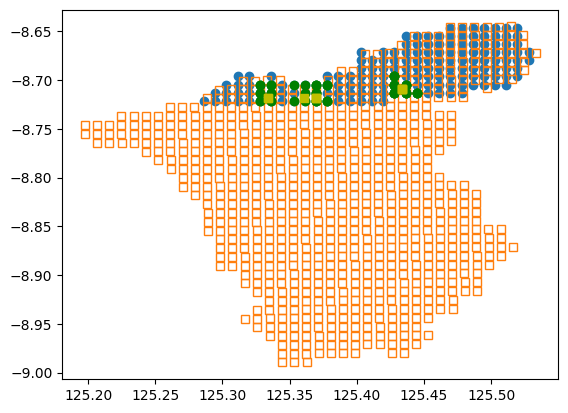

In [19]:
import pandas as pd
import numpy as np
from dynamic_models.single_step import single_step_area
from dynamic_models.visuializer import show_facility_location

#data constants
distances = pd.read_csv("../data/ermera_full/processed/distances.csv").drop(columns=["Unnamed: 0"])
homes = populations
locations = facilities
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 1
max_distance = 2
vpop = homes["Population"]


Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, vpop)

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']

show_facility_location(xC, yC, xF, yF, X=X, Z=Z, homes=homes, locations=locations, periods=periods)

TypeError: 'NoneType' object is not subscriptable

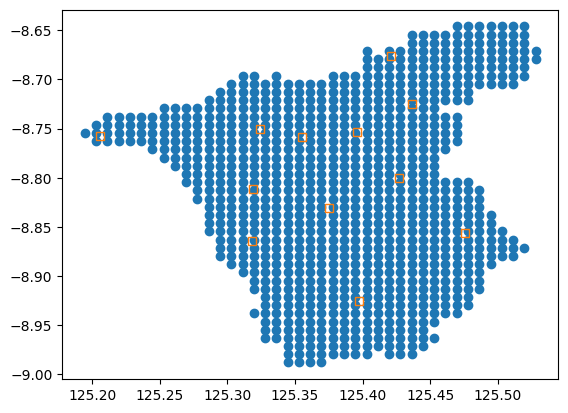

In [17]:
xC = populations_covered['Pop_Lon']
yC = populations_covered['Pop_Lat']
xF = facilities_built['Grid_Lon']
yF = facilities_built['Grid_Lat']

show_facility_location(xC, yC, xF, yF, X=None, Z=None, homes=homes, locations=locations, periods=periods)

In [ ]:
populations_covered

,Pop_Lat,Pop_Lon,Population
0,-8.646250,125.469583,32
1,-8.646250,125.477916,32
2,-8.646250,125.486250,32
3,-8.646250,125.494583,33
4,-8.646250,125.502916,37
...,...,...,...
904,-8.979583,125.436250,37
905,-8.987916,125.344583,146
906,-8.987916,125.352916,180
907,-8.987916,125.361250,172


In [ ]:
current_facilities

,Pop_Lat,Pop_Lon,Population,Grid_Lat,Grid_Lon,Distance_KM,is_built
0,-8.646250,125.469583,32,-8.758019,125.205629,59,1
1,-8.646250,125.477916,32,-8.758019,125.205629,61,1
2,-8.646250,125.486250,32,-8.758019,125.205629,61,1
3,-8.646250,125.494583,33,-8.758019,125.205629,63,1
4,-8.646250,125.502916,37,-8.758019,125.205629,63,1
...,...,...,...,...,...,...,...
10903,-8.979583,125.436250,37,-8.676029,125.420754,55,1
10904,-8.987916,125.344583,146,-8.676029,125.420754,58,1
10905,-8.987916,125.352916,180,-8.676029,125.420754,50,1
10906,-8.987916,125.361250,172,-8.676029,125.420754,49,1
